**Machine Learning Basic Principles 2018 - Data Analysis Project Report**
# Title (Comparing... in music genre classification)

## Abstract

## 1. Introduction
The task is to classify songs into different musical genres ("pop rock", "electronic"...).

## 2. Data analysis
The data represents songs which have had their audio information preprocessed into 264 features, so our data has high dimensionality. They have 10 possible classes, or music genres. The training set has 4363 songs, and the test set has 6544 songs.

The class distribution is heavily imbalanced towards "Pop Rock".

In [114]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = (14, 5)
matplotlib.rcParams['font.size'] = 12
from matplotlib import pyplot as plt

# Read data
train_data_df = pd.read_csv("data/train_data.csv", header=None)
test_data_df = pd.read_csv("data/test_data.csv", header=None)
all_data_df = train_data_df.append(test_data_df)
train_labels_df = pd.read_csv("data/train_labels.csv", header=None, 
                              names=['class'])

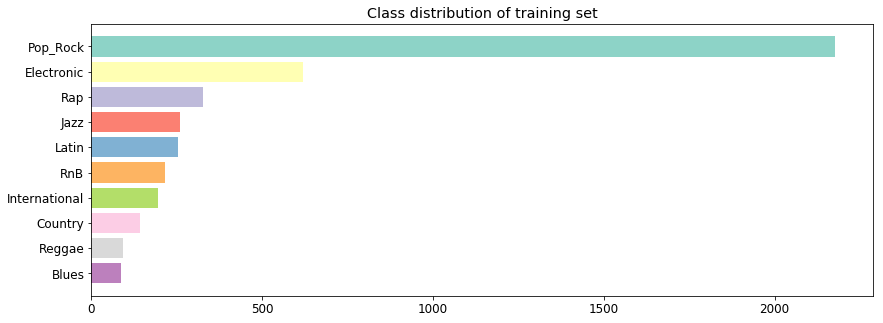

In [115]:
num_classes = 10
genres = ['Pop_Rock','Electronic','Rap','Jazz','Latin','RnB','International','Country','Reggae', 'Blues']
class_counts = train_labels_df['class'].value_counts()
cmap = plt.cm.get_cmap(plt.cm.Set3, 10)
colors = [cmap(i) for i in range(num_classes)]
plt.barh(range(num_classes)[::-1], class_counts, tick_label=genres,
         color=colors)
plt.title('Class distribution of training set')
plt.show()

In [116]:
descriptive_stats = all_data_df.describe()

In [117]:
descriptive_stats.loc[value_stats].T[70:100].T

,70,71,72,73,74,75,76,77,78,79,...,90,91,92,93,94,95,96,97,98,99
mean,1575.120179,1521.034079,4847.796874,4468.980884,4566.445585,3978.436949,4607.778729,4558.81709,4773.767828,4768.661447,...,5881.437655,6363.617108,6835.279774,7460.931814,9716.607491,6736.348483,2893.191947,4198.947718,3757.462632,3782.686555
min,-775.180000,-59.403000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.066000,1.066000,1.066000,1.066000
25%,829.225000,1000.000000,2915.450000,3062.500000,3147.600000,3073.600000,3396.600000,3400.95000,3565.250000,3534.950000,...,3671.450000,3738.650000,3711.100000,3783.250000,3636.400000,1000.000000,1923.900000,3107.900000,2879.900000,2928.850000
50%,1240.000000,1000.000000,3832.600000,3706.800000,3821.900000,3550.400000,4109.700000,4093.90000,4333.100000,4284.900000,...,4636.300000,4898.000000,4972.100000,5177.500000,4994.800000,1000.000000,2884.200000,4137.600000,3741.800000,3747.800000
75%,1802.550000,1000.000000,5454.450000,4929.500000,5212.700000,4373.600000,5218.350000,5154.75000,5460.950000,5409.750000,...,6387.700000,6777.300000,7069.600000,7460.650000,7506.450000,2487.800000,3754.450000,5259.900000,4595.450000,4596.300000
max,22423.000000,20449.000000,190290.000000,207430.000000,40388.000000,39552.000000,171660.000000,46402.00000,34826.000000,59301.000000,...,339670.000000,289810.000000,379730.000000,404640.000000,505300.000000,434260.000000,11008.000000,9984.600000,9849.800000,9591.200000


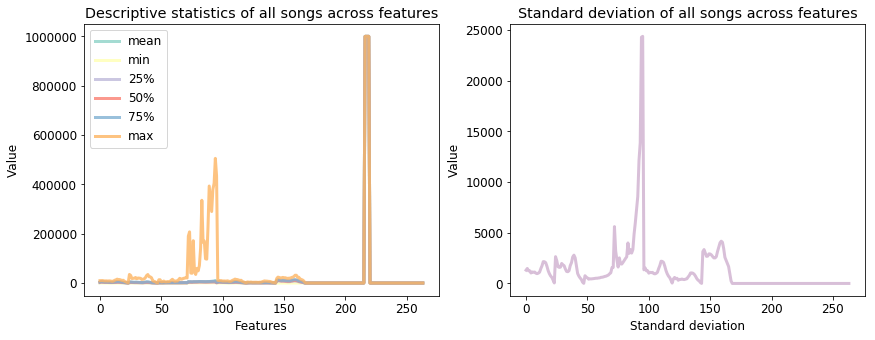

In [118]:
tab10_cmap = plt.cm.get_cmap(plt.cm.Set3, 10)
value_stats = ['mean', 'min', '25%', '50%', '75%', 'max']
plt.subplot(1, 2, 1)
for i, stat in enumerate(value_stats):
    plt.plot(descriptive_stats.loc[stat], label=stat, lw=3, alpha=0.8, color=tab10_cmap(i))
plt.ylabel("Value")
plt.xlabel("Features")
plt.legend()
plt.title("Descriptive statistics of all songs across features")

plt.subplot(1, 2, 2)
plt.plot(descriptive_stats.loc['std'], label=stat, lw=3, color='thistle')
plt.ylabel("Value")
plt.xlabel("Standard deviation")
plt.title("Standard deviation of all songs across features")

plt.show()

Features 216-219 have huge mean, min, max, and quartiles of exactly 1,000,000: this is because these features are uniformly 1,000,000 for all songs, meaning that they are **completely uninformative** and can be ignored by the training algorithm.

In [104]:
all_data_df.iloc[:, 216:220].T

,0,1,2,3,4,5,6,7,8,9,...,6534,6535,6536,6537,6538,6539,6540,6541,6542,6543
216,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,...,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
217,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,...,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
218,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,...,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
219,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,...,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0


Features 72-95, especially 72 and 88-95, also have very high max values compared to the 75th percentiles, which implies that **they have statistical outliers**. This is supported by the **unusually high variance** of features 72 and 88-95. These outliers will then impede dimensionality reduction via PCA, because the high variances will mislead PCA into heavily using these features as the primary eigenvectors.

In [129]:
train_labels_df['class'].shape

(4363,)

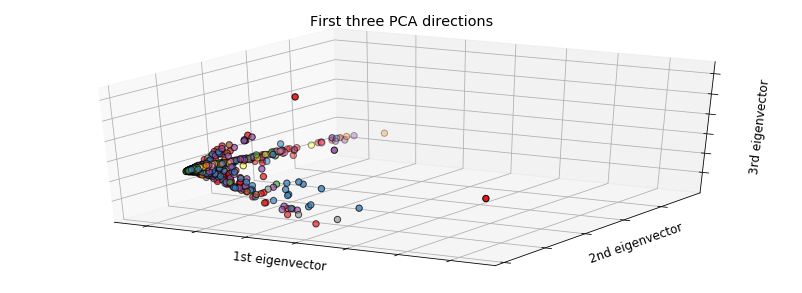

In [132]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
PCA3_data = pca.fit_transform(train_data_df)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(PCA3_data[:, 0], PCA3_data[:, 1], PCA3_data[:, 2], c=train_labels_df['class'],
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

In [95]:
all_data_df = train_data_df.append(test_data_df)
all_data_df.shape

(10907, 264)

In [96]:
train_data_df.shape

(4363, 264)

# Methods and experiments

